### Introduction

Suppose we have a bunch of URLs and we want to know their adult-rating
(i.e., is the url P, or G, or X, or R). This task is difficult for
computers, but easy for humans, and this has led to the growth of
crowdsourcing: get a bunch of humans to give ratings to urls, but
use automated techniques to figure out how much to trust each person's
ratings.

We are going to use the data from a paper by Ipeirotis *et al.*
This details an experiment run on Amazon's *Mechanical Turk* crowdsourcing system.
They ask a bunch of raters (called "turks") to rate several urls,
but they already know the answers (the true categories) for a few
urls, called the **gold set**. The ratings of the turks on the gold
set thus allows us to judge their accuracy.

### [Q1 10 points] Read in data}
Read in the files **gold.txt** and **labels.txt**.  The **gold**
DataFrame should have columns `url` and `category`, while the
**labels** DataFrame should have columns `turk`, `url` and
`category`. You will have to pick the right separator.

In [336]:
import pandas as pd
import numpy as np
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [337]:
import statsmodels.api as sm
from patsy import dmatrices

In [338]:
#loading gold and labels data and creating respective dataframes using '\t' as seperator
df_gold = pd.read_csv("gold.txt", sep='\t',header = None,names = ['url','category'])
df_labels = pd.read_csv("labels.txt",sep='\t',header = None,names = ['turk','url','category'])

In [339]:
df_gold.head()

,url,category
0,http://0800-horoscope.com,G
1,http://18games.net,X
2,http://1pixelout.net,G
3,http://1porno.com/004/teens/index.html,X
4,http://1stpussy.com/005/16/index.html,X


In [340]:
#checking for duplicates in gold dataframe
df_gold[df_gold.duplicated()]

,url,category


In [341]:
df_labels.head()

,turk,url,category
0,A1OT3A29R9N1DG,http://000.cc,P
1,A1PXXEOGQ76RNJ,http://000.cc,G
2,A1PXXEOGQ76RNJ,http://000.cc,G
3,A21US576U8SCO4,http://000.cc,G
4,A2LGX47NN7C5D3,http://000.cc,G


In [342]:
#checking for duplicates in labels dataframe
df_labels[df_labels.duplicated()]

,turk,url,category
2,A1PXXEOGQ76RNJ,http://000.cc,G
23,A1PXXEOGQ76RNJ,http://000relationships.com,G
36,A4GP97LAQCCHJ,http://000relationships.com,G
92,A1PXXEOGQ76RNJ,http://01house.cn,G
94,A21US576U8SCO4,http://01house.cn,G
...,...,...,...
92609,A21US576U8SCO4,http://zsmhl.com,G
92627,A1PXXEOGQ76RNJ,http://zucaiba.com,G
92644,APTFS1S88K5VC,http://zumin-ads.com,G
92657,A1PXXEOGQ76RNJ,http://zvezdanews.ru,G


In [343]:
#removing duplicate rows
df_labels.drop_duplicates(keep='first',inplace=True)

In [344]:
#rechecking to see if all duplicates have been removed
df_labels[df_labels.duplicated()]

,turk,url,category


### [Q2 10 points] Split into two DataFrames
Split the **labels** DataFrame into two:
* **labels_on_gold**, containing all rows where the url is present in the gold set, and
* **labels_unknown**, containing all the remaining rows of **labels**.

In [345]:
#creating labels_on_gold dataframe by creating mask
gold_url = df_gold['url'].unique().tolist()
mask = df_labels['url'].isin(gold_url)
labels_on_gold = df_labels[mask]
labels_on_gold

,turk,url,category
245,A1253FXHCZ9CWM,http://0800-horoscope.com,G
246,A153PKAL7OAY36,http://0800-horoscope.com,G
247,A1FV9SAPL5C6KY,http://0800-horoscope.com,G
248,A1JTOT0DWM6QGL,http://0800-horoscope.com,G
249,A1PXXEOGQ76RNJ,http://0800-horoscope.com,G
...,...,...,...
91766,A35CBDDGBM7T6E,http://yousendit.com,G
91767,A3J86MK3VIE6ST,http://yousendit.com,G
91768,A4GP97LAQCCHJ,http://yousendit.com,G
91769,AAQNUEUU7H1Y5,http://yousendit.com,G


In [346]:
#creating labels_unknown dataframe
mask = df_labels['url'].isin(gold_url)
labels_unknown = df_labels[~mask]
labels_unknown

,turk,url,category
0,A1OT3A29R9N1DG,http://000.cc,P
1,A1PXXEOGQ76RNJ,http://000.cc,G
3,A21US576U8SCO4,http://000.cc,G
4,A2LGX47NN7C5D3,http://000.cc,G
5,A2OVKTB7VNY8EW,http://000.cc,G
...,...,...,...
92716,AFHMR93GDJCGT,http://zz868.com,G
92717,A13F119AMOA54H,http://zzx.cc,X
92718,A1S0C0EB7A6FFM,http://zzx.cc,P
92719,A21US576U8SCO4,http://zzx.cc,G


In [347]:
#checking if there are no duplicate ros between the two dataframes
# Merge the two DataFrames using the concat function
temp_df = pd.concat([labels_on_gold, labels_unknown])

# Check for duplicate rows in the merged DataFrame
duplicate_rows = temp_df.duplicated()

# Display the duplicate rows
print("Duplicate rows:")
print(temp_df[duplicate_rows])




Duplicate rows:
Empty DataFrame
Columns: [turk, url, category]
Index: []


### [Q3 10 points] Compute accuracies of turks
Create a **rater_goodness** DataFrame that is indexed by turk, and
has two columns: the number of ratings, and the average correctness of
ratings for each turk (both on gold set urls).

In [348]:
#merging labels_on_gold and gold df on 'url'
merged_df = labels_on_gold.merge(df_gold,on='url',suffixes = ['_in_label','_in_gold'])

#creating ct_flag
merged_df['ct_flag'] = np.where(merged_df['category_in_label'] == merged_df['category_in_gold'],1,0)

#creating grouped dataframe with number of ratings and average correctness of columns
grouped_df = merged_df[['turk','ct_flag']]
rater_goodness = grouped_df.groupby('turk')['ct_flag'].agg(["count","mean"]).reset_index()
rater_goodness = rater_goodness.rename(columns = {"count":"no_of_ratings","mean":"average correctness"})
rater_goodness.set_index('turk',inplace = True)
rater_goodness

,no_of_ratings,average correctness
turk,,
A112DVP1KG4QZU,1,1.000000
A1253FXHCZ9CWM,29,0.517241
A12CY1Q7XKJJDE,1,1.000000
A12RE8G66WTO8B,20,0.750000
A12Y1GTGIQDGRA,3,0.333333
...,...,...
AYWOBMTEGFVVI,1,0.000000
AZ1S5BIG5R6P6,35,0.714286
AZSDW7JJL5VA7,100,0.680000


### [Q4 10 points] Odds ratios}
If someone is correct $p$ fraction of the time, the `odds` of
success are defined as:

$$\mbox{odds} = \frac{p}{1.001-p}.$$

Attach a column called `odds` to the **rater_goodness** DataFrame, using the average correctness of the turk as his or her $p$.

In [349]:
#calculating odds for each turk
rater_goodness['odds'] = rater_goodness['average correctness']/(1.001 - rater_goodness['average correctness'])
rater_goodness

,no_of_ratings,average correctness,odds
turk,,,
A112DVP1KG4QZU,1,1.000000,1000.000000
A1253FXHCZ9CWM,29,0.517241,1.069214
A12CY1Q7XKJJDE,1,1.000000,1000.000000
A12RE8G66WTO8B,20,0.750000,2.988048
A12Y1GTGIQDGRA,3,0.333333,0.499251
...,...,...,...
AYWOBMTEGFVVI,1,0.000000,0.000000
AZ1S5BIG5R6P6,35,0.714286,2.491281
AZSDW7JJL5VA7,100,0.680000,2.118380


### [Q5 10 points] Most accurate turks
List the top 10 most accurate turks who have rated at least 20 gold set URLs.

In [350]:
#top 10 most accurate turks with atleast 20 gold set urls
mask = rater_goodness['no_of_ratings'] >= 20
top_10_turks = rater_goodness[mask].sort_values(by='average correctness', ascending = False).head(10)
top_10_turks

,no_of_ratings,average correctness,odds
turk,,,
A2U0R4X38GUKZE,20,0.950000,18.627451
A22C0PJUBFJTI0,36,0.916667,10.869565
A23YQUBXZPKILZ,24,0.875000,6.944444
ATVALOQVDCMZW,103,0.854369,5.826657
A1HIXWH4OXT8S4,40,0.825000,4.687500
A3220HG1O83HQ4,22,0.818182,4.475385
A32W20KGQXS0LL,25,0.800000,3.980100
A20PWAB7G3HDHU,20,0.800000,3.980100
AJSJVK40F5HM6,28,0.785714,3.649635


### [Q6 10 points] Rating counts versus accuracy
One may imagine that a committed and accurate turk will rate lots of
URLs. On the other hand, perhaps it is only the spammers who have the
time to rate lots of URLs.

Is number of ratings by a turker on gold set URLs related to his or
her accuracy? There's no fixed answer; just try to show some evidence
for your answer.

<Axes: xlabel='no_of_ratings', ylabel='average correctness'>

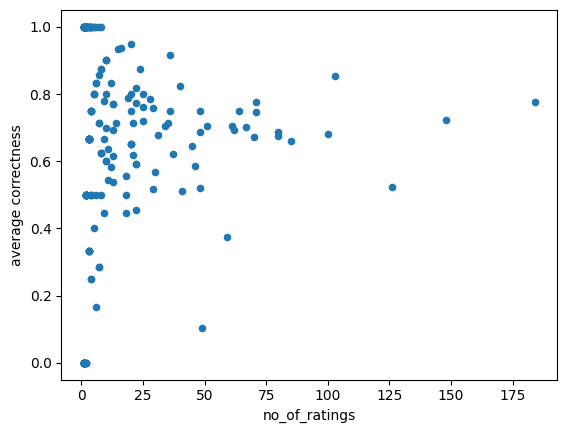

In [351]:
#Plotting scatterplot between 'no of ratings' and 'average correctness'
rater_goodness.plot(x= 'no_of_ratings',y= 'average correctness', kind = 'scatter')

## Interpretation
### average correctness do not necessarily increase with no of ratings. The scatterlot indicates that there is a wide accuracy range for lower no of ratings. Mostly the average correctness is greater than 50 % for no of ratings >25.

In [352]:
#performing a simple linear regression to see if there is a significant relationship

rater_goodness['number'] = rater_goodness['no_of_ratings']
y, X=dmatrices('odds~number',data= rater_goodness,return_type='dataframe')
model=sm.OLS(y, X)
result=model.fit()
print (result.summary())



                            OLS Regression Results                            
Dep. Variable:                   odds   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     26.77
Date:                Mon, 31 Jul 2023   Prob (F-statistic):           4.52e-07
Time:                        22:47:27   Log-Likelihood:                -2019.6
No. Observations:                 269   AIC:                             4043.
Df Residuals:                     267   BIC:                             4050.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    386.5694     30.441     12.699      0.0

## Interpretation

### regression results shows that, the number of rating counts has negative relationship with accuracy (odds).This means when turks rate more, they tend to become less accurate

### [Q7 13 points] Overall predicted odds}

Let $u$ denote any url $u$ that is *not* in the gold set, and let $c$ denote some category. 

* For every valid pair $(u, c)$, calculate the product of odds of all turks who satisfy the following two conditions: 
    1. the turk rated url $u$ as category $c$, and 
    2. he/she rated more gold set urls than 75% of all turks who rated at least one gold-set url.

For example, if you find that there are 269 turks who rated at least
one gold-set url, you want to select only the turks who have rated
more gold-set urls than 75% of these 269 turks. We can think of
these as our *"reliable"* turks. Now, our belief that url $u$ belongs
to category $c$ depends on how many reliable turks rated $u$ as $c$;
specifically, our belief is based on the product of their reliability
scores (i.e., their odds).

We shall call such products of odds the **overall odds** henceforth.

In [353]:
#segregating turks who are in the top 25 percentile of gold set ratings
greater_than_75 = rater_goodness[rater_goodness['no_of_ratings'] > rater_goodness['no_of_ratings'].quantile(0.75)].reset_index()
greater_than_75

,turk,no_of_ratings,average correctness,odds,number
0,A1253FXHCZ9CWM,29,0.517241,1.069214,29
1,A12RE8G66WTO8B,20,0.750000,2.988048,20
2,A153PKAL7OAY36,148,0.722973,2.600369,148
3,A18HIFA78GUAG9,13,0.538462,1.164144,13
4,A1DCIXV1JC91MY,22,0.590909,1.440922,22
...,...,...,...,...,...
61,AV30XWLULCP43,13,0.615385,1.595851,13
62,AVWJPWUEE3U4Q,36,0.750000,2.988048,36
63,AZ1S5BIG5R6P6,35,0.714286,2.491281,35
64,AZSDW7JJL5VA7,100,0.680000,2.118380,100


In [354]:
#validating if we fetched the correct values
rater_goodness['no_of_ratings'].describe()

count    269.000000
mean      12.338290
std       23.671273
min        1.000000
25%        1.000000
50%        3.000000
75%       11.000000
max      184.000000
Name: no_of_ratings, dtype: float64

In [355]:
#since min value > 11 (75%) hence the values are correct
greater_than_75['no_of_ratings'].min()


12

In [366]:
#merging greater_than_75 and labels unknown dataframes using turks as common key
reliable_df = greater_than_75.merge(labels_unknown,on='turk')
reliable_df['url']

0        http://007absolutehardcore.com/early_cumshots/...
1                                    http://10000birds.com
2          http://101fetishes.com/femdomtorture/portal.htm
3                                 http://101greatgoals.com
4                                     http://123movers.com
                               ...                        
37993                         http://www.blazzpage.7p.com/
37994                        http://www.byroncrawford.com/
37995                      http://www.freelayouticons.com/
37996                 http://www.hollywoodtuna.com/?p=4729
37997    http://www.ninjadude.com/index.php/joss-stone-...
Name: url, Length: 37998, dtype: object

In [357]:
#grouping by url and category and taking product of odds of turks who rated for the (url,category) combination
overall_odds = reliable_df.groupby(['url','category'])['odds'].agg(prod).reset_index()
overall_odds.set_index(['url','category'],inplace = True)
overall_odds = overall_odds.rename(columns = {'odds':'overall_odds'})
overall_odds

overall_odds
url                         category              
http://0-101.net            G             2.297602
http://000.cc               G             1.485456
http://0000.jp              G            14.339248
http://000relationships.com G             3.841962
                            P             1.851852
...                                            ...
http://zynga.com            G             3.666513
http://zz868.com            G             1.047852
                            P             1.851852
http://zzx.cc               G             1.417620
                            X             1.620746

[13983 rows x 1 columns]

### [Q8 13 points] Predicted categories
Create a DataFrame called **result_75**, with the following characteristics:
* its index is URLs not in the gold set,
* it has two columns:
    * `top category`: the category with the highest overall odds for that url, and
    * `top odds`: the overall odds for that top category.

These are our predictions, and the confidence we have in them (higher
overall odds implies greater confidence). If you want, you can
check to see if the predicted categories make sense.

In [358]:
#creating result_75 dataframe with top category and overall odds columns
temp_df = overall_odds.reset_index()
result_75 = temp_df.loc[temp_df.groupby('url')['overall_odds'].idxmax()]
result_75 = result_75.rename(columns = {'category':'top_category'})
result_75

,url,top_category,overall_odds
0,http://0-101.net,G,2.297602
1,http://000.cc,G,1.485456
2,http://0000.jp,G,14.339248
3,http://000relationships.com,G,3.841962
5,http://000vitamins.com,G,4.033641
...,...,...,...
13976,http://zwinky.com,G,17.201875
13977,http://zylom.com,G,1.849543
13978,http://zynga.com,G,3.666513
13980,http://zz868.com,P,1.851852


### [Q9 14 points] Predicted categories using more turks
Questions 7 and 8 above only considered the ratings of turks who had
rated enough gold set URLs, so we were relatively more confident about
their accuracies. What happens if we loosen this restriction?

Repeat the code of Q7 and Q8, but replacing 75% by 25% in the description of Q7 (i.e., we also consider turks who have far fewer gold set ratings).
Call this **result_25**.

Now let's see how these two results compare. 
Create a DataFrame where both the index and the columns are the
various categories, and the cells contain the number of urls with
these as the top categories according to **result_75** and **result_25**.

For example, the cell corresponding to the row `category=R`
and the column `category=G` would be the number of URLs that were predicted to
be *R* by **result_75** but predicted to be *G* by **result_25**.

Where are the most errors?

In [360]:
#creating result_25 by repeating steps in Q7 and Q8

greater_than_25 = rater_goodness[rater_goodness['no_of_ratings'] > rater_goodness['no_of_ratings'].quantile(0.25)].reset_index()
merged_df = greater_than_25.merge(labels_unknown,on='turk')
overall_odds_25 = merged_df.groupby(['url','category'])['odds'].agg(prod).reset_index()
overall_odds_25.set_index(['url','category'],inplace = True)
overall_odds_25 = overall_odds_25.rename(columns = {'odds':'overall_odds'})
temp_df_25 = overall_odds_25.reset_index()
result_25 = temp_df_25.loc[temp_df_25.groupby('url')['overall_odds'].idxmax()]
result_25 = result_25.rename(columns = {'category':'top_category'})
result_25

,url,top_category,overall_odds
0,http://0-101.net,G,2.297602e+00
1,http://000.cc,G,2.218192e+03
3,http://0000.jp,G,2.847963e+07
5,http://000relationships.com,P,1.851852e+00
7,http://000vitamins.com,G,5.343559e+00
...,...,...,...
16682,http://zwinky.com,P,1.000000e+03
16683,http://zylom.com,G,3.062113e+03
16684,http://zynga.com,G,5.386158e+01
16685,http://zz868.com,G,1.209566e+13


In [361]:
#Merging result_75 and result_25 and keeping just the category column
merged_result = result_75.merge(result_25, on = 'url', suffixes = ['_75','_25'])
merged_result = merged_result[['top_category_75','top_category_25']]
merged_result 




,top_category_75,top_category_25
0,G,G
1,G,G
2,G,G
3,G,P
4,G,G
...,...,...
10605,G,P
10606,G,G
10607,G,G
10608,P,G


In [362]:
#creating pivot table with rows as result_75 categories, column as result_25 categories and values as counts
results = pd.crosstab(merged_result['top_category_75'],merged_result['top_category_25'])
results

top_category_25,G,P,R,X
top_category_75,,,,
G,8280,586,180,214
P,196,352,52,25
R,22,34,127,25
X,28,5,28,456


In [365]:
#calculating error% of each category
accuracy_per_category = np.diag(results) / np.sum(results, axis=1)

index = ['G','P','X','R']
# Create a new DataFrame to store the accuracy for each category
accuracy_df = pd.DataFrame({'Category': index, 'Accuracy': accuracy_per_category})

print(accuracy_df)

                Category  Accuracy
top_category_75                   
G                      G  0.894168
P                      P  0.563200
R                      X  0.610577
X                      R  0.882012


# Result Interpretation

### Prediction accuracy for category P is the lowest and hence it has the most errors